**Load data**

In [1]:
import pandas as pd
import numpy as np

# Load austinHousingData.csv into DataFrame
df = pd.read_csv('/kaggle/input/austin-house-prices/austinHousingData.csv')
df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [2]:
#subset data
df_subset= df[
    (df['propertyTaxRate'] == 1.98) & 
    (df['hasView'] == 1) & 
    (df['numOfBedrooms'] >= 2) &  
    (df['latestPrice'] <= 1000000) &
    (df['avgSchoolRating'] >= 4)
]

print(f"Number of observations meeting all specified conditions: {len(df_subset)}")

Number of observations meeting all specified conditions: 2084


**Prep data for insight #1**

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Prep scaling functions
scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

# Perform standardization
df_subset['standardPrice'] = scaler.fit_transform(df_subset[['latestPrice']])
df_subset['minmaxPrice'] = min_max_scaler.fit_transform(df_subset[['latestPrice']])

# Create price categories
bins = [-np.inf,-1,1,np.inf]
labels = ['budget', 'mid-range', 'premium']
df_subset.loc[:,'standardPrice_category'] = pd.cut(df_subset.loc[:,'standardPrice'], bins=bins, labels=labels)

# Create price categories
bins = [0,0.25,0.75,1]
labels = ['budget', 'mid-range', 'premium']
df_subset.loc[:,'minmaxPrice_category'] = pd.cut(df_subset.loc[:,'minmaxPrice'], bins=bins, labels=labels)

/tmp/ipykernel_18/3036144017.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['standardPrice'] = scaler.fit_transform(df_subset[['latestPrice']])
/tmp/ipykernel_18/3036144017.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['minmaxPrice'] = min_max_scaler.fit_transform(df_subset[['latestPrice']])
/tmp/ipykernel_18/3036144017.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [4]:
# Count values 
print(df_subset['standardPrice_category'].value_counts())
print(df_subset['minmaxPrice_category'].value_counts())


standardPrice_category
mid-range    1395
premium       364
budget        325
Name: count, dtype: int64
minmaxPrice_category
mid-range    1644
premium       284
budget        155
Name: count, dtype: int64


**Create KNN regression for insight #1**

In [5]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#KNN regression for longitude & latitude
X_Long_Lat = df_subset[['longitude','latitude']]
Y_Price = df_subset['latestPrice']

Long_Lat_knn_reg = KNeighborsRegressor(n_neighbors=3, metric = 'manhattan')
Long_Lat_knn_reg.fit(X_Long_Lat,Y_Price)

Y_Long_Lat_knn_reg_pred = Long_Lat_knn_reg.predict(X_Long_Lat)

#model characteristics/statistics
print("Regression R-Squared: ", r2_score(Y_Price, Y_Long_Lat_knn_reg_pred))

print("KNN Regression MAE:", mean_absolute_error(Y_Price, Y_Long_Lat_knn_reg_pred))
print("KNN Regression MSE:", mean_squared_error(Y_Price, Y_Long_Lat_knn_reg_pred))
print("KNN Regression RMSE:", mean_squared_error(Y_Price, Y_Long_Lat_knn_reg_pred, squared=False))

import matplotlib.pyplot as plt
import numpy as np


Regression R-Squared:  0.7042723397791701
KNN Regression MAE: 79261.47472808702
KNN Regression MSE: 11930474554.792067
KNN Regression RMSE: 109226.71172745276


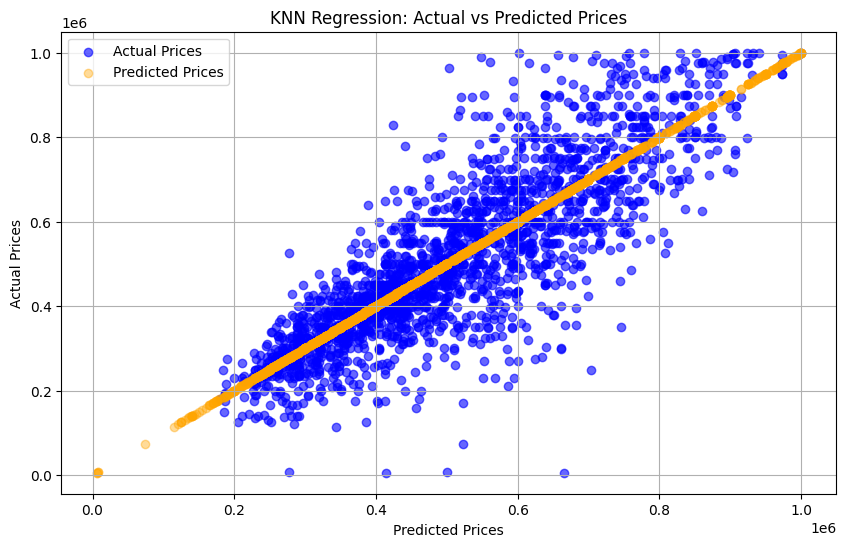

In [6]:
# Scatter plot of actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(Y_Long_Lat_knn_reg_pred, Y_Price, color='blue', alpha=0.6, label='Actual Prices')
plt.scatter(Y_Price, Y_Price, color='orange', alpha=0.4, label='Predicted Prices')
plt.title('KNN Regression: Actual vs Predicted Prices')
plt.xlabel('Predicted Prices')
plt.ylabel('Actual Prices')
plt.legend()
plt.grid(True)
plt.show()

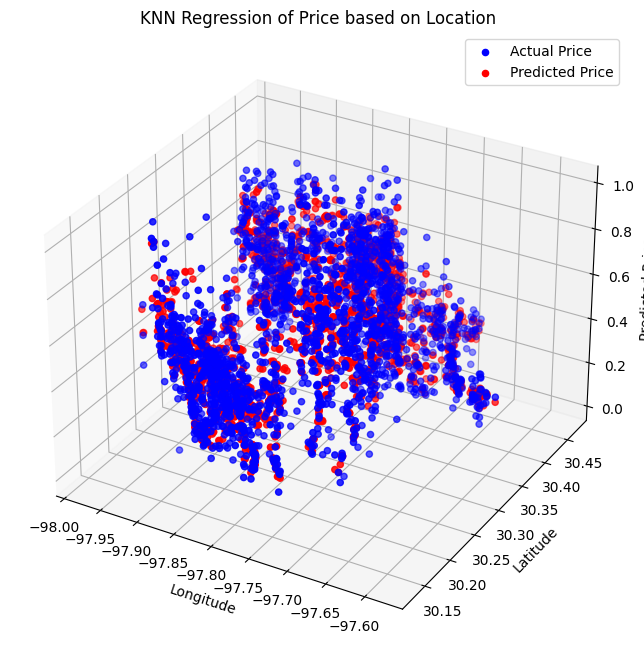

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of longitude, latitude, and predicted price
ax.scatter(df_subset['longitude'], df_subset['latitude'], df_subset['latestPrice'], c='blue', marker='o', label='Actual Price')
ax.scatter(df_subset['longitude'], df_subset['latitude'], Y_Long_Lat_knn_reg_pred, c='red', marker='o', label='Predicted Price')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Predicted Price')
ax.set_title('KNN Regression of Price based on Location')
plt.legend()
plt.show()

**Create KNN classifier for insight #1**

In [8]:
# Investigate and drop NA value
print(df_subset['minmaxPrice_category'].isna().sum())
df_subset = df_subset.dropna(subset = ['minmaxPrice_category'])
print(df_subset['minmaxPrice_category'].isna().sum())

1
0


In [9]:
from sklearn.metrics import accuracy_score

#Basic KNN classification for longitude & latitude
X_Long_Lat = df_subset[['longitude', 'latitude']]
Y_PriceCategory = df_subset['minmaxPrice_category']

Long_Lat_knn_class = KNeighborsClassifier(n_neighbors=3, metric = 'manhattan')
Long_Lat_knn_class.fit(X_Long_Lat,Y_PriceCategory)

Y_Long_Lat_knn_class_pred = Long_Lat_knn_class.predict(X_Long_Lat)
print("KNN classification accuracy score: ",accuracy_score(Y_PriceCategory,Y_Long_Lat_knn_class_pred))

KNN classification accuracy score:  0.8665386461833894


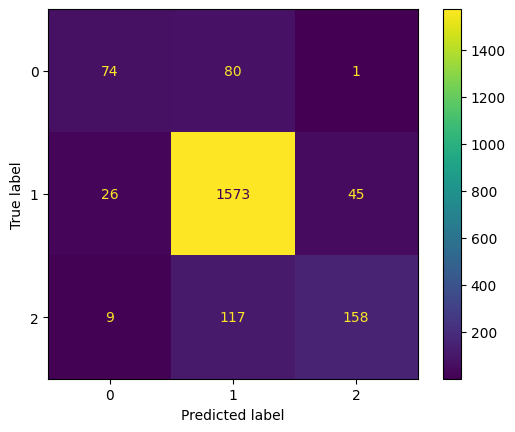

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
Long_Lat_KNN_cm = confusion_matrix(Y_PriceCategory,Y_Long_Lat_knn_class_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=Long_Lat_KNN_cm)
disp.plot()

In [11]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(Long_Lat_knn_class, X_Long_Lat, Y_PriceCategory, cv=3, scoring='accuracy')

# Print the model performance measures
print("Accuracy for each fold:", scores)
print("Mean Accuracy across all folds:", np.mean(scores))

Accuracy for each fold: [0.56690647 0.74495677 0.67291066]
Mean Accuracy across all folds: 0.6615913033262152


**End of insight #1**

**Starting insight #2**

Reset the data with the consistent filter ensuring it runs properly

In [12]:
import pandas as pd
import numpy as np

# Load austinHousingData.csv into DataFrame
df = pd.read_csv('/kaggle/input/austin-house-prices/austinHousingData.csv')
df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [13]:
#subset data
df_subset= df[
    (df['propertyTaxRate'] == 1.98) & 
    (df['hasView'] == 1) & 
    (df['numOfBedrooms'] >= 2) &  
    (df['latestPrice'] <= 1000000) &
    (df['avgSchoolRating'] >= 4)
]

print(f"Number of observations meeting all specified conditions: {len(df_subset)}")

Number of observations meeting all specified conditions: 2084


In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = df_subset[['avgSchoolRating', 'livingAreaSqFt', 'numOfBedrooms', 'numOfBathrooms', 'hasGarage', 'hasCooling']]
y = df_subset['latestPrice']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Output the number of decision trees in the Random Forest
num_trees = rf_model.n_estimators
print(f"Number of decision trees in the Random Forest: {num_trees}")

# Define a function to predict latestPrice and calculate R-squared
def predict_latestPrice(avgSchoolRating, livingAreaSqFt, numOfBedrooms, numOfBathrooms, hasGarage, hasCooling, model, X_train, df):
    # Prepare input data as DataFrame
    input_data = pd.DataFrame({
        'avgSchoolRating': [avgSchoolRating],
        'livingAreaSqFt': [livingAreaSqFt],
        'numOfBedrooms': [numOfBedrooms],
        'numOfBathrooms': [numOfBathrooms],
        'hasGarage': [hasGarage],
        'hasCooling': [hasCooling]
    })
    
    # Predict latestPrice using the model
    predicted_price = model.predict(input_data)
    
    # Calculate R-squared on the training data
    y_train_pred = model.predict(X_train)
    r_squared = r2_score(y_train, y_train_pred)
    
    # Filter observations that match the input characteristics using inequalities
    df_subset2 = df[(df['avgSchoolRating'] >= avgSchoolRating) & 
                    (df['livingAreaSqFt'] >= livingAreaSqFt) & 
                    (df['numOfBedrooms'] >= numOfBedrooms) & 
                    (df['numOfBathrooms'] >= numOfBathrooms) & 
                    (df['hasGarage'] >= hasGarage) & 
                    (df['hasCooling'] >= hasCooling)]
    
    return predicted_price[0], r_squared, df_subset2  # Return the predicted price, R-squared, and new dataset

avgSchoolRating_value = 5
livingAreaSqFt_value = 1500
numOfBedrooms_value = 3
numOfBathrooms_value = 2
hasGarage_value = 1
hasCooling_value = 1

predicted_price, r_squared, df_subset2 = predict_latestPrice(
    avgSchoolRating_value, livingAreaSqFt_value, numOfBedrooms_value, numOfBathrooms_value, hasGarage_value, hasCooling_value, rf_model, X_train, df_subset
)
# Predict the latestPrice for each row in df_subset2
df_subset2['predicted_latestPrice'] = rf_model.predict(df_subset2[['avgSchoolRating', 'livingAreaSqFt', 'numOfBedrooms', 'numOfBathrooms', 'hasGarage', 'hasCooling']])

df_subset2.loc[:, 'price_difference'] = df_subset2['predicted_latestPrice'] - df_subset2['latestPrice']

import numpy as np

# Calculate MAPE
df_subset2['percentage_difference'] = ((df_subset2['predicted_latestPrice'] - df_subset2['latestPrice']) / df_subset2['latestPrice']) * 100
mape = df_subset2['percentage_difference'].mean()
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Remove 'latestPrice' column and store it temporarily
latestPrice = df_subset2.pop('latestPrice')

df_subset2['latestPrice'] = latestPrice

print(f"Predicted latestPrice for avgSchoolRating>={avgSchoolRating_value}, livingAreaSqFt>={livingAreaSqFt_value}, numOfBedrooms>={numOfBedrooms_value}, numOfBathrooms>={numOfBathrooms_value}, hasGarage>={hasGarage_value}, hasCooling>={hasCooling_value}: ${predicted_price:.2f}")
print(f"R-squared on training data: {r_squared:.4f}")
print(f"Number of observations that match the input characteristics: {len(df_subset2)}")

df_subset2.head(10)


Number of decision trees in the Random Forest: 100
Mean Absolute Percentage Error (MAPE): 14.05%
Predicted latestPrice for avgSchoolRating>=5, livingAreaSqFt>=1500, numOfBedrooms>=3, numOfBathrooms>=2, hasGarage>=1, hasCooling>=1: $346776.00
R-squared on training data: 0.9035
Number of observations that match the input characteristics: 1047


/tmp/ipykernel_18/920382013.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset2['predicted_latestPrice'] = rf_model.predict(df_subset2[['avgSchoolRating', 'livingAreaSqFt', 'numOfBedrooms', 'numOfBathrooms', 'hasGarage', 'hasCooling']])
/tmp/ipykernel_18/920382013.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset2.loc[:, 'price_difference'] = df_subset2['predicted_latestPrice'] - df_subset2['latestPrice']
/tmp/ipykernel_18/920382013.py:67: SettingWithCopyWarning: 
A value is trying 

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,predicted_latestPrice,price_difference,percentage_difference,latestPrice
28,70333917,austin,12525 Verandah Ct,78726,Welcome to the Estates of Grandview Hills. Th...,30.426456,-97.859291,1.98,2,True,...,1277,16,4.0,4,2,70333917_38e0174e92f0a3743d95f5d04f1d5a71-p_f.jpg,871815.00,-3185.00,-0.364000,875000.0
58,29376490,austin,10615 Beckwood Dr,78726,Affordable home in highly desired Canyon Creek...,30.442228,-97.825111,1.98,2,True,...,1275,15,3.0,5,1,29376490_6cc91f2ddfc3cd71e81a079fe62c4f97-p_f.jpg,507432.57,22432.57,4.625272,485000.0
82,29370898,austin,12726 Cloud Mountain Xing,78726,VIEWS for miles in this Grandview Hills home. ...,30.423340,-97.864410,1.98,2,True,...,1277,16,4.0,4,2,29370898_b7a4095625679818e62ddcb0fc7ee163-p_f.jpg,655936.50,106036.50,19.282870,549900.0
95,29372475,austin,9008 Scotsman Dr,78750,Stunning complete renovation situated perfectl...,30.428507,-97.794250,1.98,2,True,...,1616,16,3.0,4,2,29372475_a8bc2b2002340b1caabb5312d728bd11-p_f.jpg,621170.56,-62829.44,-9.185591,684000.0
100,29373974,austin,8711 Crest Ridge Cir,78750,This 4BD/2.5 bath plus study sits on a beautif...,30.435591,-97.785774,1.98,2,True,...,1632,16,2.0,4,1,29373974_63156988f43efa7c8066bdf9447cffcd-p_f.jpg,446407.65,11407.65,2.622448,435000.0
101,29360984,austin,7601 Almond Cv,78750,Immaculate property w beautiful traditional fi...,30.380716,-97.789558,1.98,2,True,...,1523,17,3.0,4,2,29360984_0f41daba314e5845c30d3e680d1899b1-p_f.jpg,742960.00,-52040.00,-6.545912,795000.0
107,29347484,austin,4202 Plantain Cv,78730,Gated 3+ acre private estate with walking path...,30.356325,-97.837234,1.98,3,True,...,1381,16,7.0,5,2,29347484_d5b8a2496f8b041ccffeefcfb39c3d96-p_f.jpg,787972.00,-11028.00,-1.380225,799000.0
112,29375973,austin,9010 Spring Lake Dr,78750,"9010 Spring Lake Dr, Austin, TX 78750 is a sin...",30.438555,-97.794724,1.98,5,True,...,1632,16,3.0,4,2,29375973_cd7ca8a6c4aa99a615309ae1224fb5f5-p_f.jpg,566688.81,-62311.19,-9.906390,629000.0
129,29370850,austin,8121 Endeavor Cir,78726,"Beautiful, grand, immaculate, single owner hom...",30.424416,-97.860558,1.98,2,True,...,1277,16,4.0,5,2,29370850_d8a1b96226836fa6236d53cd75751010-p_f.jpg,740192.00,75192.00,11.307068,665000.0
138,70352470,austin,804 Lakewood Hills Ter,78732,Wake up each morning to breathtaking views of ...,30.354076,-97.913033,1.98,3,True,...,1533,17,4.0,4,2,70352470_82a2d24745ac58972ba1517b10aed28a-p_f.jpg,690392.00,-34608.00,-4.773517,725000.0


We wanted to create a model where we could predict the price of a house based on important variables to Kee as well as those we found had a high R squared value like livingAreaSqFt. this takes into account 6 variables and produces a predicted latestPrice for a house meeting the characteristics with a 90.35% accuracy. We chose >=5 avgschool rating, >=1500 living rea, >=3 bedrooms, >=2 bathrooms, >=1 garage and >=1 cooling system and created a new dataset of 1047 houses that fit these metrics as we try working our way to a final recommendation for kee. We also added the variable predicted_latestPrice into our dataset where we get a predicted price based on the random forest 90.35% accuracy model. to help evaluate this we added the columns price_difference and percentage_difference. Negative values in both columns show that the predicted price is higher then the actual price meaning bad value and if the values are positive this could identify potential value purchase for Kee based on our model

In [15]:
df_subset2 = df_subset2.sort_values(by='percentage_difference', ascending=False)
df_subset2.head(10)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,predicted_latestPrice,price_difference,percentage_difference,latestPrice
14580,29339192,austin,2800 Westlake Dr,78746,"Fabulous, sunny and comfortable in peaceful We...",30.309500,-97.781631,1.98,2,False,...,1669,15,4.5,4,2,29339192_cdac2583788ba6e3bb3d40da5285b375-p_f.jpg,286412.000000,278512.000000,3525.468354,7900.0
5796,70337317,austin,1812 Eagles Glen Cv,78732,Ideally situated in the prestigious gated Univ...,30.355019,-97.892174,1.98,3,True,...,1533,17,4.0,5,2,70337317_287bd61606a97c14ca110f64e823fbb6-p_f.jpg,170394.000000,164794.000000,2942.750000,5600.0
4823,29492341,austin,8801 Young Ln,78737,Coming soon! This exclusive home is not listed...,30.213013,-97.921234,1.98,3,True,...,1655,18,5.0,6,2,29492341_abb893089860e58045f09b51842c7db5-p_f.jpg,216463.000000,208463.000000,2605.787500,8000.0
10996,29424378,austin,6304 Gidleigh Ct,78754,Cul-de-sac corner lot home with breathtaking p...,30.356461,-97.614235,1.98,6,True,...,1049,11,2.0,4,1,29424378_streetviewlocation6304GidleighCt2CAus...,544902.060000,375402.060000,221.476142,169500.0
4198,29419875,austin,11251 Avering Ln,78754,Ready for quick move-in home with amazing gree...,30.346188,-97.608986,1.98,2,True,...,1049,11,3.0,3,2,29419875_2dae483f7b949e954ec7546898006e5d-p_f.jpg,594500.946667,359500.946667,152.979126,235000.0
9732,29386092,austin,2016 Peoples St,78702,Striking 1935 restoration featuring gorgeous t...,30.267824,-97.717323,1.98,1,False,...,697,11,4.0,5,1,29386092_8349d9c9343f44a88bd12990e62a21ec-p_f.jpg,283453.940000,168453.940000,146.481687,115000.0
5401,83829544,austin,4228 Verano Dr,78735,"Impeccable, contemporary-style and Heyl Homes ...",30.276699,-97.886314,1.98,3,True,...,1332,16,5.0,4,1,83829544_e448ed53f49c8126b5da323609f02a1b-p_f.jpg,770060.000000,455060.000000,144.463492,315000.0
11026,83821227,austin,11904 Gaelic Dr,78754,Beautiful cozy home with a wonderful greenbelt...,30.359612,-97.616379,1.98,2,True,...,1049,11,2.0,3,1,83821227_a1b7aa3d4acead92f3eda610c01c50b3-p_f.jpg,303781.460000,173781.460000,133.678046,130000.0
13273,29505142,austin,6547 Needham Ln,78739,Large home ready for move in. Spacious floor p...,30.188454,-97.894470,1.98,2,True,...,1755,18,4.0,5,2,29505142_7c4ff338e58d305e8eed2aca1cd8ad5b-p_f.jpg,697316.780000,372316.780000,114.559009,325000.0
5326,70331730,austin,5824 Sunset Rdg,78735,Gorgeous home situated on large corner lot. 5 ...,30.255117,-97.886818,1.98,2,True,...,1455,17,4.0,5,2,70331730_6994b5b0477d4af7150ae862276b5ec1-p_f.jpg,732982.540000,377982.540000,106.473955,355000.0


We notice when sorting the values that there are some very large difference which seems unrealistic so our next step is to remove outliers from the dataset

In [16]:
import pandas as pd
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_subset2['percentage_difference'].quantile(0.25)
Q3 = df_subset2['percentage_difference'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_subset2 = df_subset2[(df_subset2['percentage_difference'] >= lower_bound) & (df_subset2['percentage_difference'] <= upper_bound)]

# Print the DataFrame without outliers to verify the change
df_subset2.head(10)

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage,predicted_latestPrice,price_difference,percentage_difference,latestPrice
12370,29484343,austin,6621 Debcoe Dr,78749,Open and airy 2-story home is well suited for ...,30.224939,-97.875595,1.98,2,True,...,1494,17,3.0,3,2,29484343_7ec42b53b3570626cf1b4cf729e9fe82-p_f.jpg,371008.70,106018.70,40.008566,264990.0
5246,29480774,austin,6303 Sanderson Ave,78749,Awesome home in super convenient location,30.225060,-97.836899,1.98,2,False,...,1494,17,2.0,4,1,29480774_5cdaeb2895b61401aa50b9cdfd4dd7e4-p_f.jpg,529533.00,150033.00,39.534387,379500.0
7156,29515904,austin,2206 Hazeltine Ln,78747,Amazing updated Onion Creek Contemporary: Feat...,30.141516,-97.791344,1.98,2,True,...,1506,15,3.0,3,2,29515904_e7e32c065ecb30b2da2193c0271a6177-p_f.jpg,438658.70,123758.70,39.300953,314900.0
14526,29337173,austin,2804 Oakmont Blvd,78703,This stunning one-story home is situated on a ...,30.302994,-97.757736,1.98,1,False,...,1298,16,2.0,3,1,29337173_142f88225b58a673f110da66ed183bc2-p_f.jpg,507961.11,142961.11,39.167427,365000.0
7425,70357559,austin,10501 Channel Island Dr,78747,"10501 Channel Island Dr, Austin, TX 78747 is a...",30.149439,-97.786446,1.98,2,True,...,1506,15,3.0,5,2,70357559_5c59f831ddb99ff8b3a84b815c10a332-p_f.jpg,305303.75,85403.75,38.837540,219900.0
5346,29477689,austin,7306 Scenic Brook Dr,78736,Wonderfully updated home with a huge shaded ya...,30.238403,-97.892525,1.98,2,False,...,1698,17,2.0,4,2,29477689_1afcdb300b60882bf44d2adb9ad7fb6e-p_f.jpg,356364.00,99664.00,38.825088,256700.0
8995,29449596,austin,14704 Great Willow Dr,78728,"Great single story, 3 /2 in highly desirable W...",30.444580,-97.680969,1.98,2,False,...,1348,14,2.0,3,1,29449596_d09ddb2f00144b7fe6fab3935242d929-p_f.jpg,228298.00,63398.00,38.446331,164900.0
13963,64515854,austin,7328 Covered Bridge Dr,78736,"Gorgeous hill country views, updates throughou...",30.241566,-97.900276,1.98,4,True,...,1237,15,4.0,4,2,64515854_72c07d2fd735735b57fbf047784fab1d-p_f.jpg,712362.57,197474.57,38.352918,514888.0
8615,58305189,austin,11964 Dorsett Rd,78727,"2 Story Brick Home, large backyard, Shady Oak ...",30.413841,-97.727249,1.98,2,False,...,1486,15,3.0,3,2,58305189_7a6b1773a5cc81b4ff3a86fcd28358c5-p_f.jpg,536830.00,147830.00,38.002571,389000.0
8519,29365262,austin,6510 Delmonico Dr,78759,Rare Find in Spectacular Great Hills! Well mai...,30.407221,-97.771561,1.98,2,False,...,1638,16,2.0,3,1,29365262_e20c8623e2b96081c93b071a869d3f16-p_f.jpg,620954.00,170954.00,37.989778,450000.0


Now we have got ride of outliers and see that there are many options with around a 30% price difference between our predicted price and what it is currently listed at. Next step is to narrow it down to our 100 most valued houses to lead into our appreciation insight and recommendation

In [17]:
import pandas as pd


df_subset2_best_values = df_subset2.nlargest(100, 'percentage_difference')

# Counting observations in df_subset2_best_values
num_observations = len(df_subset2_best_values)
print(f"Number of observations in df_subset2_best_values: {num_observations}")

# Checking for NaN values in df_subset2_best_values
num_nan_values = df_subset2_best_values.isna().sum().sum()
if num_nan_values > 0:
    print(f"There are {num_nan_values} NaN values in df_subset2_best_values.")
else:
    print("There are no NaN values in df_subset2_best_values.")

Number of observations in df_subset2_best_values: 100
There are no NaN values in df_subset2_best_values.


This is where we create the new data set of the 100 best value houses for kee to look at and for what will be used in our recommendation

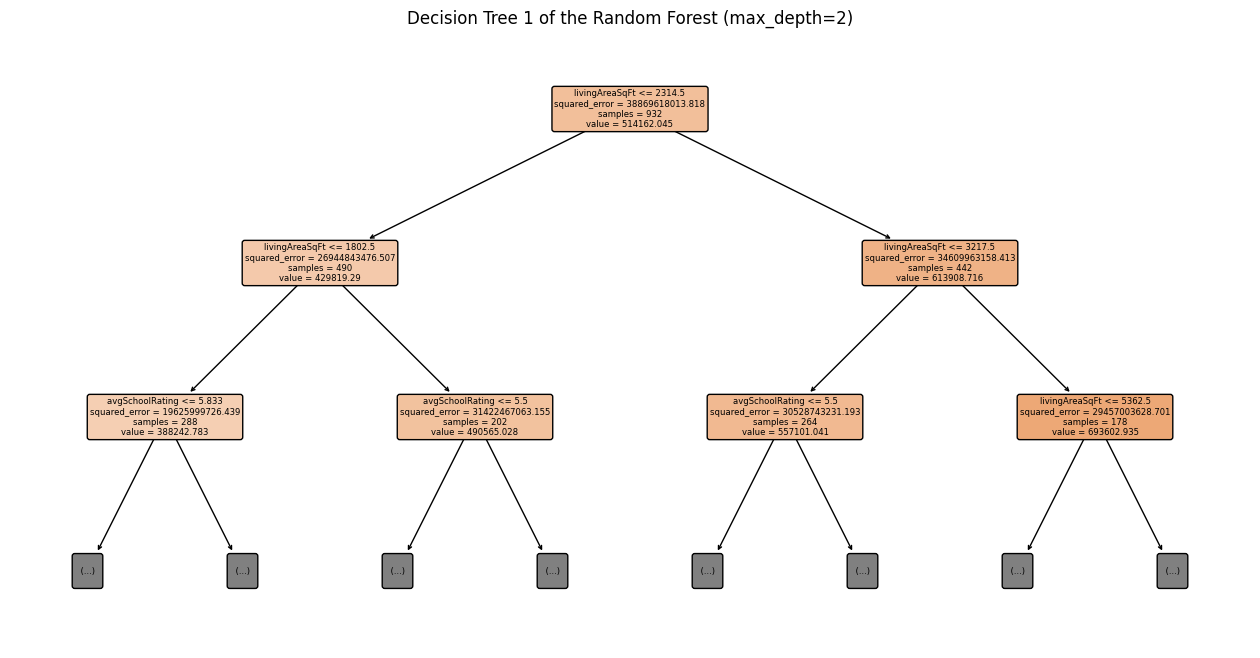

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming df_subset is already defined as your dataframe

# Define the feature set and target variable
X = df_subset[['avgSchoolRating', 'livingAreaSqFt', 'numOfBedrooms', 'numOfBathrooms', 'hasGarage', 'hasCooling']]
y = df_subset['latestPrice']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)  # You can set the number of trees with n_estimators
rf_model.fit(X_train, y_train)

# Function to visualize the first few trees in the Random Forest with limited depth
def visualize_simplified_trees(rf_model, num_trees=1, max_depth=2):
    # Check if the model is fitted
    if not hasattr(rf_model, "estimators_"):
        raise ValueError("The model is not fitted yet!")

    # Visualize the first few trees
    for i in range(min(num_trees, len(rf_model.estimators_))):
        plt.figure(figsize=(16, 8))  # Adjust the figsize to make the plot smaller
        plot_tree(rf_model.estimators_[i], feature_names=X.columns, filled=True, rounded=True, max_depth=max_depth)
        plt.title(f'Decision Tree {i+1} of the Random Forest (max_depth={max_depth})')
        plt.show()

# Visualize the first 3 trees in the Random Forest with a maximum depth of 3
visualize_simplified_trees(rf_model, num_trees=1, max_depth=2)

this code is for educational purposes to get a sample of a decision tree within the random forest sample to help show the class what the model is doing

**Starting Insight #3**

Reset the data with the consistent filter ensuring it runs properly

In [19]:
import pandas as pd
import numpy as np
# Load austinHousingData.csv into DataFrame
df = pd.read_csv('/kaggle/input/austin-house-prices/austinHousingData.csv')
df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [20]:
import pandas as pd

df_similar = df[
    (df['propertyTaxRate'] == 1.98) &
    (df['hasView'] == 1) & 
    (df['numOfBedrooms'] >= 2) &
    (df['latestPrice'] <= 1000000) &
    (df['avgSchoolRating'] >= 4) &
    (df['homeType'] != 'Vacant Land') &
    (df['hasGarage'] == True) &
    (df['numOfBathrooms'] == 2)]

print(df_subset.head())
print(f"Number of observations meeting all specified conditions: {len(df_similar)}")

         zpid    city              streetAddress  zipcode  \
28   70333917  austin          12525 Verandah Ct    78726   
58   29376490  austin          10615 Beckwood Dr    78726   
82   29370898  austin  12726 Cloud Mountain Xing    78726   
95   29372475  austin           9008 Scotsman Dr    78750   
100  29373974  austin       8711 Crest Ridge Cir    78750   

                                           description   latitude  longitude  \
28   Welcome to the Estates of Grandview Hills.  Th...  30.426456 -97.859291   
58   Affordable home in highly desired Canyon Creek...  30.442228 -97.825111   
82   VIEWS for miles in this Grandview Hills home. ...  30.423340 -97.864410   
95   Stunning complete renovation situated perfectl...  30.428507 -97.794250   
100  This 4BD/2.5 bath plus study sits on a beautif...  30.435591 -97.785774   

     propertyTaxRate  garageSpaces  hasAssociation  ...  numOfMiddleSchools  \
28              1.98             2            True  ...                  

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_18/2923296874.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_similar['Cluster'] = kmeans.fit_predict(lat_lon_data)


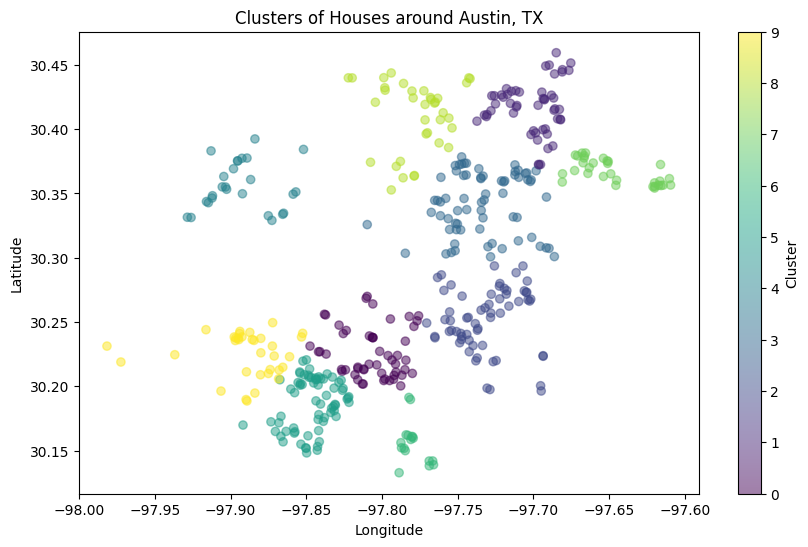

In [21]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Normalize the latitude and longitude values if necessary
lat_lon_data = df_similar[['latitude', 'longitude']]

# K-Means clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=33)
df_similar['Cluster'] = kmeans.fit_predict(lat_lon_data)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_similar['longitude'], df_similar['latitude'], c=df_similar['Cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Houses around Austin, TX')
plt.show()

In [22]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Identify the largest cluster
largest_cluster = df_similar['Cluster'].value_counts().idxmax()

# Create a new subset of data containing only the houses in the largest cluster
df_largest_cluster = df_similar[df_similar['Cluster'] == largest_cluster]

# Print the number of houses in the largest cluster
print(f"Number of houses in the largest cluster: {df_largest_cluster.shape[0]}")

# convert latest_saledate to datetime format
df_largest_cluster['latest_saledate'] = pd.to_datetime(df_largest_cluster['latest_saledate'], errors='coerce')

# Extract the year from the 'latest_saledate' if not already done
df_largest_cluster['latest_saleyear'] = df_largest_cluster['latest_saledate'].dt.year

# Calculate the average latest_saleyear and average latestPrice for the cluster
average_latest_saleyear = df_largest_cluster['latest_saleyear'].mean()
average_latest_price = df_largest_cluster['latestPrice'].mean()

# Calculate the years between the average latest_saleyear and the latest sale year for each house
df_largest_cluster['years_between_sales'] = df_largest_cluster['latest_saleyear'] - average_latest_saleyear

# Ensure there are no zero or negative years
df_largest_cluster = df_largest_cluster[df_largest_cluster['years_between_sales'] > 0]

# Calculate the annual appreciation rate using the average latest price (CAGR)
df_largest_cluster['annual_appreciation'] = ((df_largest_cluster['latestPrice'] / average_latest_price) ** (1 / df_largest_cluster['years_between_sales']) - 1) * 100

# Calculate the average annual appreciation rate
average_annual_appreciation = df_largest_cluster['annual_appreciation'].mean()

# Print results
print("Average Annual Appreciation Rate: {:.2f}%".format(average_annual_appreciation))

Number of houses in the largest cluster: 69
Average Annual Appreciation Rate: 7.99%


/tmp/ipykernel_18/1081078740.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_largest_cluster['latest_saledate'] = pd.to_datetime(df_largest_cluster['latest_saledate'], errors='coerce')
/tmp/ipykernel_18/1081078740.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_largest_cluster['latest_saleyear'] = df_largest_cluster['latest_saledate'].dt.year
/tmp/ipykernel_18/1081078740.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

This value should produce an average annual appreciation rate of 7.99% and a number of houses of 69

**Combining the two insights**

#### Now that we have a list of 100 viable houses, let's combine that with the CAGR that we got from insight #3 to present our client with an investment opportunity

#### Before doing that, there is one problem: Let's say we are projecting the house price 10 years. If the latest saleprice (from the list of 100 houses) is old, then we wouldn't be accurately predicting the profitability of an investment. To get around this, we need to filter the list of 100 houses EVEN MORE to project ONLY the houses with the most recent latest_saleyear. So, let's take the top 10 most recently sold houses, and project THOSE prices out 10 years from now using the CAGR.

In [23]:
# Ensure the 'latest_saledate' is in datetime format
df_subset2_best_values['latest_saledate'] = pd.to_datetime(df_subset2_best_values['latest_saledate'], errors='coerce')

# Extract the year from the 'latest_saledate' if not already done
df_subset2_best_values['latest_saleyear'] = df_subset2_best_values['latest_saledate'].dt.year

# Sort the DataFrame by 'latest_saleyear' in descending order
df_sorted = df_subset2_best_values.sort_values(by='latest_saleyear', ascending=False)

# Select the top 10 houses with the most recent 'latest_saleyear'
top_10_recent_houses = df_sorted.head(10)

# Print the results
print("Top 10 houses with the most recent latest_saleyear:")
print(top_10_recent_houses[['zpid', 'latest_saleyear', 'latestPrice', 'yearBuilt', 'latitude', 'longitude']])

Top 10 houses with the most recent latest_saleyear:
            zpid  latest_saleyear  latestPrice  yearBuilt   latitude  \
4505   121657577             2020     258000.0       2014  30.346369   
11008  111370819             2020     166246.0       2012  30.358244   
2654    29376603             2020     550000.0       1990  30.439032   
2156   114406960             2020     247000.0       2011  30.141993   
12006   70335354             2020     280000.0       2006  30.154291   
5807    63834805             2020     259000.0       2003  30.363199   
649     29376401             2020     439900.0       1998  30.438925   
7554    29512614             2020     245000.0       1976  30.164907   
1731    29359140             2020     369900.0       1997  30.373474   
2258    29361436             2020     419000.0       1999  30.382776   

       longitude  
4505  -97.618156  
11008 -97.619926  
2654  -97.824997  
2156  -97.768143  
12006 -97.841644  
5807  -97.904518  
649   -97.817200  
755

In [24]:
cagr = average_annual_appreciation / 100

# Assume you want to project the value 5 years into the future
years_into_future = 5

# Calculate the projected value using the formula: Future Value = Present Value * (1 + CAGR)^n
top_10_recent_houses['projected_value'] = top_10_recent_houses['latestPrice'] * ((1 + cagr) ** years_into_future)

# Print the results
print("Top 10 houses with the most recent latest_saleyear and their projected values:")
print(top_10_recent_houses[['zpid', 'latest_saleyear', 'latestPrice', 'projected_value', 'yearBuilt', 'latitude', 'longitude']])

Top 10 houses with the most recent latest_saleyear and their projected values:
            zpid  latest_saleyear  latestPrice  projected_value  yearBuilt  \
4505   121657577             2020     258000.0    378944.545296       2014   
11008  111370819             2020     166246.0    244178.352238       2012   
2654    29376603             2020     550000.0    807827.519042       1990   
2156   114406960             2020     247000.0    362787.994915       2011   
12006   70335354             2020     280000.0    411257.646058       2006   
5807    63834805             2020     259000.0    380413.322604       2003   
649     29376401             2020     439900.0    646115.137503       1998   
7554    29512614             2020     245000.0    359850.440301       1976   
1731    29359140             2020     369900.0    543300.725989       1997   
2258    29361436             2020     419000.0    615417.691780       1999   

        latitude  longitude  
4505   30.346369 -97.618156  
11

/tmp/ipykernel_18/1003315417.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_recent_houses['projected_value'] = top_10_recent_houses['latestPrice'] * ((1 + cagr) ** years_into_future)
